# Neutralizations for DMS validation

In [33]:
import os
import warnings

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
from plotnine import position_dodge

import altair as alt

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml
plt.rcParams['svg.fonttype'] = 'none'
print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 2.1.0


In [34]:
warnings.simplefilter('ignore')

Read config file.

In [50]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [51]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [52]:
frac_infect = pd.read_csv(config['serum_neuts_all'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [53]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= True)

In [54]:
fitparams = (
    fits.fitParams(ics=[50,90])
    .assign(NT50=lambda x: 1/x['ic50'])
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [55]:
fitparams.to_csv('results/neut_titers.csv', index=False)


In [56]:
color_list = ['#808080', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#000000']

## Plot neut curves

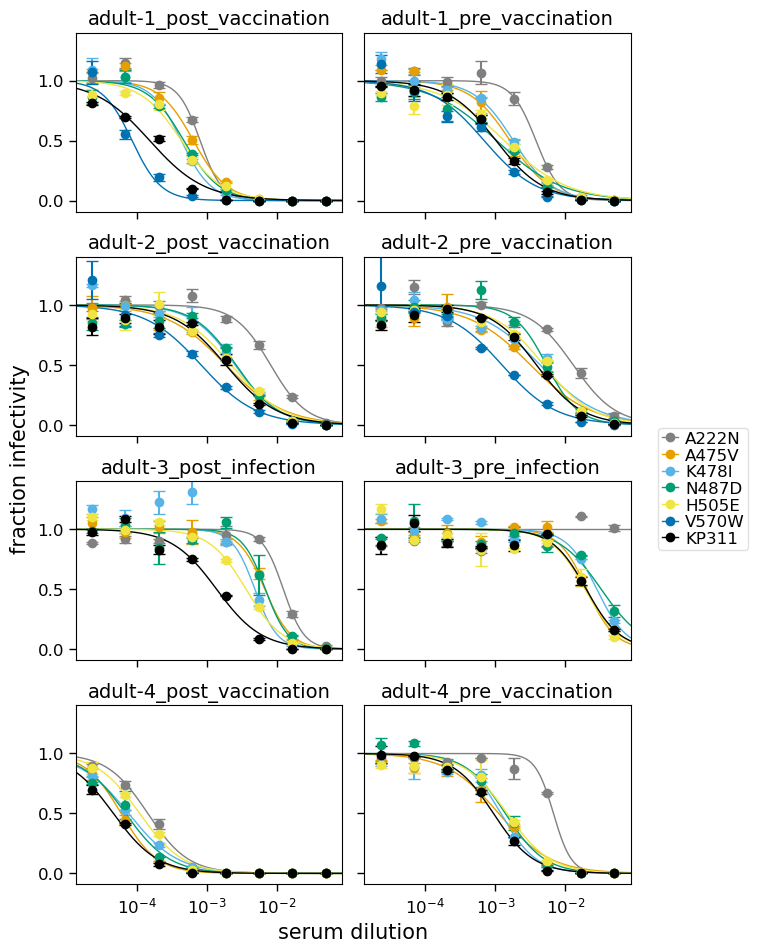

In [57]:
fig, axes = fits.plotSera(xlabel='serum dilution',
                          ncol=2,
                          max_viruses_per_subplot = 7,
                          markers=['o','o','o','o','o','o','o'],
                          colors = color_list
                         )
plotfile_pdf = 'sera_validation_all_neuts.pdf'
plotfile_svg = 'validation_all_neuts.svg'
fig.savefig(f'{resultsdir}/{plotfile_pdf}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_svg}', bbox_inches='tight')

In [58]:
adult_sera_escape = config['adult_sera_escape']
adult_sera_escape = pd.read_csv(adult_sera_escape)
adult_sera_escape['mutation'] = adult_sera_escape['wildtype']+adult_sera_escape['site']+adult_sera_escape['mutant']

In [59]:
adult_sera_escape['mutation'] = adult_sera_escape['wildtype']+adult_sera_escape['site']+adult_sera_escape['mutant']

In [60]:
merged_df = adult_sera_escape[["mutation", "antibody", "escape"]].merge(
    fitparams[["virus", "serum", 'ic50']],
    left_on=["mutation", "antibody"],
    right_on=["virus", "serum"],
    how="inner" 
)
merged_df = merged_df[['serum','ic50','mutation','escape']]
merged_df

,serum,ic50,mutation,escape
0,adult-1_post_vaccination,0.000799,A222N,0.600600
1,adult-1_post_vaccination,0.000640,A475V,0.439600
2,adult-1_post_vaccination,0.000432,K478I,0.240500
3,adult-1_post_vaccination,0.000468,N487D,0.396000
4,adult-1_post_vaccination,0.000432,H505E,0.370500
5,adult-1_post_vaccination,0.000085,V570W,-0.554000
6,adult-1_pre_vaccination,0.003807,A222N,0.440000
7,adult-1_pre_vaccination,0.001621,A475V,0.035610
8,adult-1_pre_vaccination,0.001811,K478I,-0.085510
9,adult-1_pre_vaccination,0.001042,N487D,0.005445


In [61]:
fitparams_kp311 = fitparams[fitparams["virus"] == "KP311"]
fitparams_kp311 = fitparams_kp311[["serum","ic50"]]
fitparams_kp311['mutation'] = 'WT'
fitparams_kp311['escape'] = '0'
fitparams_kp311

,serum,ic50,mutation,escape
6,adult-1_post_vaccination,0.000152,WT,0
13,adult-1_pre_vaccination,0.001022,WT,0
20,adult-2_post_vaccination,0.001855,WT,0
27,adult-2_pre_vaccination,0.003864,WT,0
33,adult-3_post_infection,0.001373,WT,0
39,adult-3_pre_infection,0.019872,WT,0
45,adult-4_post_vaccination,0.000046,WT,0
51,adult-4_pre_vaccination,0.000941,WT,0


In [62]:
concatenated_df = pd.concat(
    [fitparams_kp311, merged_df],
    ignore_index=True
)
concatenated_df["ic50"] = pd.to_numeric(concatenated_df["ic50"], errors="coerce")
concatenated_df["escape"] = pd.to_numeric(concatenated_df["escape"], errors="coerce")

concatenated_df

,serum,ic50,mutation,escape
0,adult-1_post_vaccination,0.000152,WT,0.000000
1,adult-1_pre_vaccination,0.001022,WT,0.000000
2,adult-2_post_vaccination,0.001855,WT,0.000000
3,adult-2_pre_vaccination,0.003864,WT,0.000000
4,adult-3_post_infection,0.001373,WT,0.000000
5,adult-3_pre_infection,0.019872,WT,0.000000
6,adult-4_post_vaccination,0.000046,WT,0.000000
7,adult-4_pre_vaccination,0.000941,WT,0.000000
8,adult-1_post_vaccination,0.000799,A222N,0.600600
9,adult-1_post_vaccination,0.000640,A475V,0.439600


In [63]:
serums = concatenated_df['serum'].unique()
correlation_data = []

for serum in serums:
    subset = concatenated_df[concatenated_df['serum'] == serum]
    log_ic50 = np.log(subset['ic50'])
    correlation = log_ic50.corr(subset['escape'])
    correlation_data.append({'serum': serum, 'correlation_text': f"R = {correlation:.2f}"})

correlation_df = pd.DataFrame(correlation_data)

correlation_df

,serum,correlation_text
0,adult-1_post_vaccination,R = 0.97
1,adult-1_pre_vaccination,R = 0.88
2,adult-2_post_vaccination,R = 0.94
3,adult-2_pre_vaccination,R = 0.96
4,adult-3_post_infection,R = 0.87
5,adult-3_pre_infection,R = 0.95
6,adult-4_post_vaccination,R = 0.52
7,adult-4_pre_vaccination,R = 0.98


In [64]:
rows_of_charts = []

current_row_charts = []
for serum in serums:
    subset = concatenated_df[concatenated_df['serum'] == serum]
    
    base_chart = alt.Chart(subset).encode(
        x=alt.X("ic50", title="ic50", scale=alt.Scale(type="log")),
        y=alt.Y("escape", title="DMS measured escape"),
        color=alt.Color("mutation", title="mutation"),
        tooltip=[
            alt.Tooltip(c, format=".3g") if subset[c].dtype == float else c
            for c in subset.columns.tolist()
        ]
    )

    # Plot points
    points = base_chart.mark_point(filled=True, size=70, opacity=0.6)
    
    correlation_text = correlation_df[correlation_df['serum'] == serum]['correlation_text'].values[0]
    
    # Annotation
    text_chart = alt.Chart(pd.DataFrame({'x': [subset['ic50'].max()], 'y': [subset['escape'].max()], 'text': [correlation_text]})).mark_text(dx=-10, dy=-10).encode(
        x='x:Q',
        y='y:Q',
        text='text'
    )
    
    chart = (points + text_chart).properties(width=200, height=200, title=serum)
    
    # Add to the current row
    current_row_charts.append(chart)
    
    # If the row is complete or we're on the last serum
    if len(current_row_charts) == 4 or serum == serums[-1]:
        rows_of_charts.append(alt.hconcat(*current_row_charts))
        current_row_charts = []

# Vertically concatenate the rows of charts
combined_chart = alt.vconcat(*rows_of_charts)

combined_chart.configure_axis(grid=False)


alt.VConcatChart(...)

In [72]:
colors = ['#000000','#808080', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [74]:
# Map serum values to the x-positions for the dashed lines
serum_to_line_position = {
    serums[0]: 0.000152,
    serums[1]: 0.001022,
    serums[2]: 0.001855,
    serums[3]: 0.003864,
    serums[4]: 0.001373,
    serums[5]: 0.019872,
    serums[6]: 0.000046,
    serums[7]: 0.000941
}


# Extract unique virus values in their order of appearance
virus_order = concatenated_df['mutation'].drop_duplicates().tolist()

# Ensure that the number of colors matches the number of unique virus values
if len(virus_order) > len(colors):
    raise ValueError("Number of colors doesn't match the number of unique virus values!")

rows_of_charts = []
current_row_charts = []

for serum in serums:
    subset = concatenated_df[concatenated_df['serum'] == serum]
    
    # Base Chart
    base_chart = alt.Chart(subset).encode(
        x=alt.X("ic50", title="pseudovirus neutralization (IC50)", scale=alt.Scale(type="log", nice=False, padding = 10)),
        y=alt.Y("escape", title="DMS measured escape", scale=alt.Scale(padding = 10)),
        # Use the provided colors list for the color encoding
        color=alt.Color("mutation", title="mutation", scale=alt.Scale(domain=virus_order, range=colors), sort=alt.SortField('order', order='ascending')),
        tooltip=[
            alt.Tooltip(c, format=".3g") if subset[c].dtype == float else c
            for c in subset.columns.tolist()
        ]
    )

     # Plot points
    points = base_chart.mark_point(filled=True, size=120, opacity=0.6)
    
    correlation_text = correlation_df[correlation_df['serum'] == serum]['correlation_text'].values[0]
    
    # Annotation
    text_chart = alt.Chart(pd.DataFrame({'text': [correlation_text]})).mark_text(dx=5, dy=15).encode(
        x=alt.value(20),  # Fixed x-position
        y=alt.value(5),   # Fixed y-position
        text='text'
    )
    
    # Dashed line based on serum value
    line_position = serum_to_line_position.get(serum)
    if line_position:
        rule_chart = alt.Chart(pd.DataFrame({'x': [line_position]})).mark_rule(color='gray', strokeDash=[2, 2]).encode(x='x:Q')
    else:
        rule_chart = alt.Chart(pd.DataFrame()).mark_rule().encode(x='x:Q')  # Empty chart if serum doesn't have a specific line

    # Combining the plot, text, and rule
    combined_chart = points + text_chart + rule_chart
    
    chart = combined_chart.properties(width=200, height=200, title=serum)
    
    # Add to the current row
    current_row_charts.append(chart)
    
    # If the row is complete or we're on the last serum
    if len(current_row_charts) == 4 or serum == serums[-1]:
        rows_of_charts.append(alt.hconcat(*current_row_charts))
        current_row_charts = []

# Vertically concatenate the rows of charts
final_chart = alt.vconcat(*rows_of_charts)


# plotfile = 'DMS_vs_serum_escape.html'
# final_chart.configure_axis(grid=False).save(f'{resultsdir}/{plotfile}', embed_options={'renderer':'svg'})
final_chart.configure_axis(grid=False)

alt.VConcatChart(...)